# Traditional Machine Learning

## Goals
1.  Define and use appropriate evaluation metrics (RMSE, MAE, R²) for regression with a log-transformed target.
2.  Implement two traditional ML models and compare their performance:
    -   **Ridge Regression**: Linear Regression with L2 Regularization
    -   **XGBoost Regressor**: Performant Random Forest Regressor
3. Explore a **Voting Ensemble** combining both approaches

In [83]:
# Imports
from pathlib import Path

import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

import joblib 

In [71]:
# Constants
CLEANED_FILE_PATH: str = "../../data/cleaned/regression"
MODELS_SAVE_PATH: str = "../../models/regression"
FIGURES_SAVE_PATH: str = "../../figures"

RANDOM_STATE: int = 42
N_SPLITS: int = 5 

In [72]:
# Load data
output_dir = Path(CLEANED_FILE_PATH)

X_train = pl.read_csv(output_dir / "X_train_engineered.csv")
X_val = pl.read_csv(output_dir / "X_val_engineered.csv")

y_train_log = pl.read_csv(output_dir / "y_train_log.csv")["annual_salary_log"]
y_val_log = pl.read_csv(output_dir / "y_val_log.csv")["annual_salary_log"]

In [73]:
# Let's also setup a quick way to evaluate the models as we go
def inverse_transform_salary(log_salary_pred: np.ndarray) -> dict[str, str]:
    """Applies np.expm1 (inverse of np.log1p) to convert log-transformed salaries back."""
    return np.expm1(log_salary_pred)

def evaluate_model(model, X: pl.DataFrame, y_true_log: pl.Series, model_name: str) -> dict:
    """
    Evaluates a model on log-transformed data and reports metrics on both log and original scales.
    """
    y_pred_log = model.predict(X)
    
    # Metrics on log scale
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log)) # Root Mean-Squared-Error for Linear Models
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)

    # Metrics on original scale
    y_true_orig = inverse_transform_salary(y_true_log.to_numpy())
    y_pred_orig = inverse_transform_salary(y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig) 
    
    print(f"--- {model_name} ---")
    print(f"RMSE (log-scale): {rmse_log:.4f}")
    print(f"MAE (log-scale): {mae_log:.4f}")
    print(f"R2 (log-scale): {r2_log:.4f}")
    print(f"RMSE (original-scale): ${rmse_orig:,.2f}")
    print(f"MAE (original-scale): ${mae_orig:,.2f}")
    print(f"R2 (original-scale): {r2_orig:.4f}") 
    
    return {
        'model_name': model_name,
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'r2_log': r2_log,
        'rmse_orig': rmse_orig,
        'mae_orig': mae_orig,
        'r2_orig': r2_orig
    }

## Ridge Regression
As a baseline, let's start with the simplest model, linear regression.

In [74]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, y_train_log)

ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_model.fit(X_train, y_train_log)

# Compare on validation set
lr_results = evaluate_model(lr_model, X_val, y_val_log, "Linear Regression")
print("")
ridge_results = evaluate_model(ridge_model, X_val, y_val_log, "Ridge Regression")

joblib.dump(ridge_model, Path(MODELS_SAVE_PATH) / "ridge_model.pkl")

--- Linear Regression ---
RMSE (log-scale): 0.4106
MAE (log-scale): 0.3168
R2 (log-scale): 0.4076
RMSE (original-scale): $50,854.54
MAE (original-scale): $31,345.15
R2 (original-scale): 0.3030

--- Ridge Regression ---
RMSE (log-scale): 0.4106
MAE (log-scale): 0.3168
R2 (log-scale): 0.4076
RMSE (original-scale): $50,854.69
MAE (original-scale): $31,344.97
R2 (original-scale): 0.3030


['../../models/regression/ridge_model.pkl']

A RMSE of $50,854.54 is rather high, but within expectations as annual salary is a noisy target and hard to correlate with linear relationships.

Let's also take a look at which features the model values.

In [75]:
# Display top N and bottom N coefficients
n: int = 10

feature_coefficients = pl.DataFrame(
    {"Feature": X_train.columns, "Coefficient": ridge_model.coef_}
).sort(by="Coefficient", descending=True)

print(f"\nTop {n} Positive Coefficients for Ridge Regression:")
display(feature_coefficients.head(n))

print(f"\nTop {n} Negative Coefficients for Ridge Regression:")
display(feature_coefficients.tail(n))


Top 10 Positive Coefficients for Ridge Regression:


Feature,Coefficient
str,f64
"""experience_field_years_ordinal""",0.196389
"""industry_Computing or Tech""",0.184528
"""education_ordinal""",0.139518
"""gender_Man""",0.120618
"""experience_overall_years_ordin…",0.096806
"""industry_Law""",0.082963
"""industry_Engineering or Manufa…",0.060512
"""job_level_director""",0.059352
"""job_level_vp""",0.056735



Top 10 Negative Coefficients for Ridge Regression:


Feature,Coefficient
str,f64
"""industry_Retail""",-0.019727
"""industry_Social Work""",-0.025896
"""industry_Education (Primary/Se…",-0.035537
"""industry_Nonprofits""",-0.044259
"""education_experience_interacti…",-0.048721
"""job_level_c_level""",-0.054175
"""job_level_other""",-0.054382
"""industry_Education (Higher Edu…",-0.061841
"""gender_Non-binary""",-0.104662


Let's also visualise these coefficients.

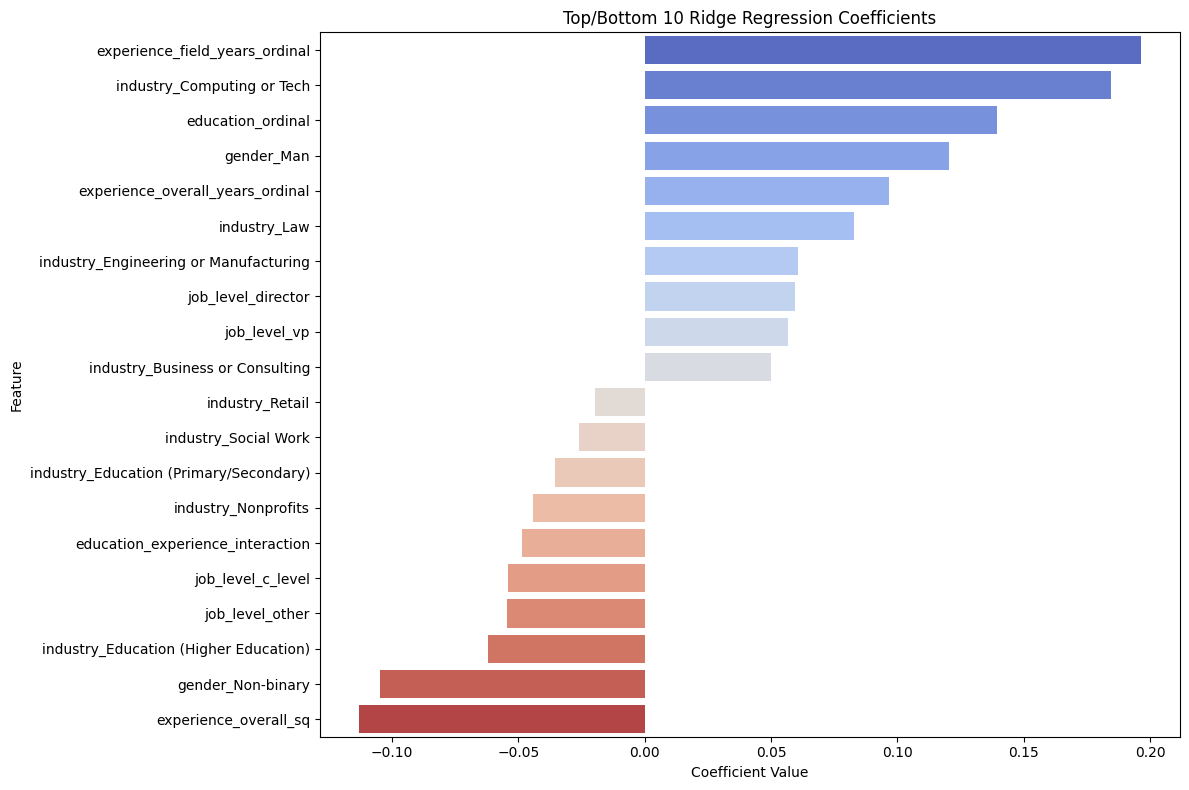

In [76]:
# Visualize coefficients
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Coefficient",
    y="Feature",
    data=pl.concat([feature_coefficients.head(n), feature_coefficients.tail(n)], how="vertical"),
    hue="Feature",
    palette="coolwarm",
)
plt.title(f"Top/Bottom {n} Ridge Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "lr_coefficients.png", dpi=300)
plt.show()

Most of these features have very low correlation (<10%). 

Notably, Field Experience, Computing or Tech industries, Education, and being a male have moderate positive correlations (>10%), which aligns with standard expectations.

Oddly, the overall experience squared engineered feature has the greatest negative correlation. 

## XGBoost Regressor

XGBoost improves upon Random Forest Regressors by introducing regularisation into leaf nodes to address overfitting.

✓ Random Forest Regressor (Baseline) model trained and saved.

--- Random Forest Regressor Model (Training) ---
RMSE (log-scale): 0.1735
MAE (log-scale): 0.1290
R2 (log-scale): 0.8943
RMSE (original-scale): $24,569.69
MAE (original-scale): $13,561.54
R2 (original-scale): 0.8363

--- Random Forest Regressor Model (Validation) ---
RMSE (log-scale): 0.4260
MAE (log-scale): 0.3268
R2 (log-scale): 0.3623
RMSE (original-scale): $51,581.40
MAE (original-scale): $32,322.90
R2 (original-scale): 0.2829


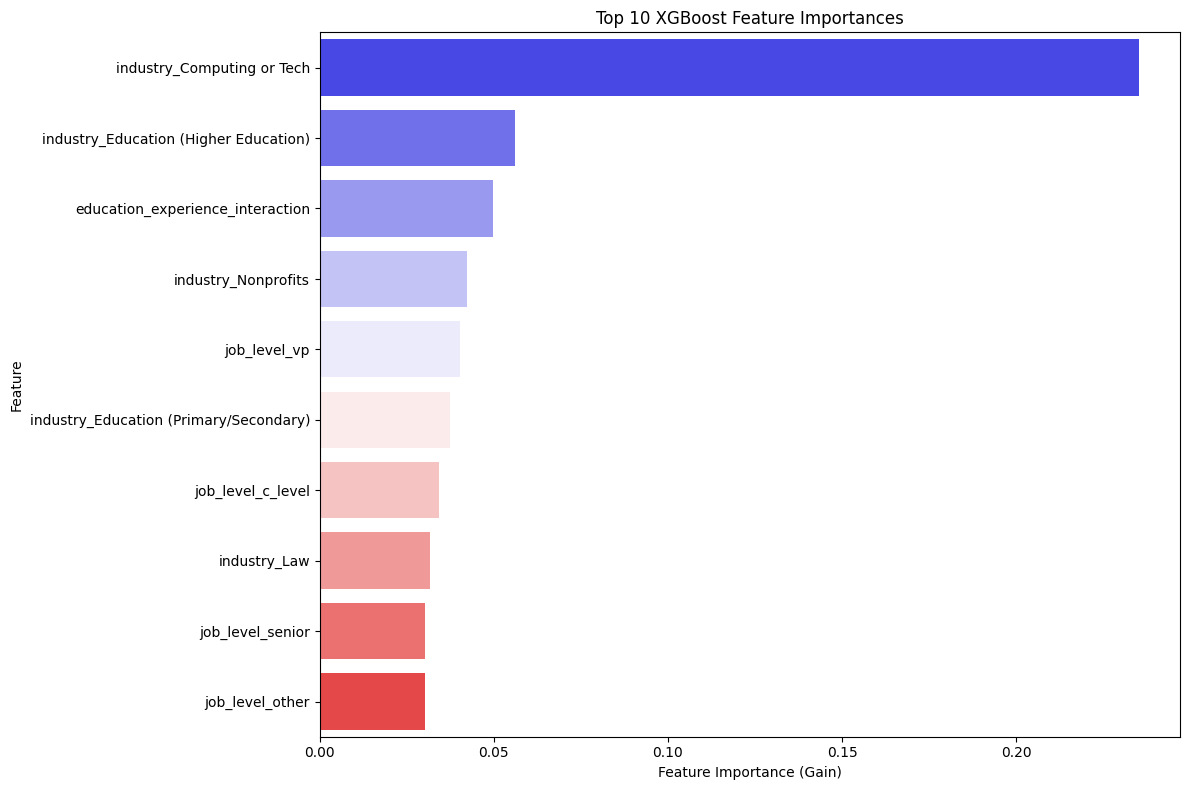

In [82]:
rf_model = RandomForestRegressor(
    n_estimators=100, # Default
    random_state=RANDOM_STATE,
    n_jobs=-1, # Use all available cores
    max_features=0.7 # Using 70% of features for each tree
)
rf_model.fit(X_train, y_train_log)

# Save the model
joblib.dump(rf_model, Path(MODELS_SAVE_PATH) / "rf_model_baseline.pkl")
print("✓ Random Forest Regressor (Baseline) model trained and saved.\n")

evaulation = evaluate_model(rf_model, X_train, y_train_log, "Random Forest Regressor Model (Training)")
print("")
evaluation = evaluate_model(rf_model, X_val, y_val_log, "Random Forest Regressor Model (Validation)")


plt.figure(figsize=(12, 8))
sns.barplot(
	x="Importance",
    y="Feature",
	data=feature_importances_xgb.head(n),  # Use top N
    hue="Feature",
	palette="bwr",
    legend=False,
)
plt.title(f"Top {n} XGBoost Feature Importances")
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "xgb_feature_importance.png", dpi=300)
plt.show()

Looking at the validation results, the XGBoost model has very consistent results with Ridge Regression, having a similar RMSE around $50,000.

More interestingly, the XGBoost Regressor seems to value Computing or Tech industry much more than Ridge Regression. 

## Stacking Regressor
Stacking Regressor works by combining the predictions of multiple base models.

While a simple `VotingRegressor` averages predictions, stacking goes a step further by training a **meta-model** (the `final_estimator`) to learn how to best combine the predictions of the base estimators.

In [78]:
estimators = [
    ("ridge", Ridge(random_state=RANDOM_STATE, alpha=1.0)),
    ("xgb", XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1, tree_method='hist'))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(random_state=RANDOM_STATE, alpha=0.1), 
    cv=5, 
    passthrough=True,
    n_jobs=-1,
)
stacking_model.fit(X_train, y_train_log)

joblib.dump(stacking_model, Path(MODELS_SAVE_PATH) / "stacking_model.pkl")

stacking_results = evaluate_model(stacking_model, X_val, y_val_log, "Stacking Regressor")

--- Stacking Regressor ---
RMSE (log-scale): 0.3944
MAE (log-scale): 0.3043
R2 (log-scale): 0.4534
RMSE (original-scale): $49,313.35
MAE (original-scale): $30,288.22
R2 (original-scale): 0.3446


## Cross-Validation
For a fair comparison, let's also redo the comparison with cross-validation.

In [84]:
models = {
    "Ridge Regression": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist",
    ),
    "Stacking Regressor": StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(random_state=RANDOM_STATE, alpha=0.1),
        cv=5,
        passthrough=True,
        n_jobs=-1,
    ),
}

cv_results = {}
for name, model in models.items():
    # Use negative RMSE for cross_val_score
    scores = cross_val_score(
        model,
        X_train,
        y_train_log,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    rmse_scores = -scores  # Convert back to positive RMSE
    cv_results[name] = rmse_scores
    
    print(f"{name}:")
    print(f"  Mean RMSE: {rmse_scores.mean():.4f}")
    print(f"  Std RMSE:  {rmse_scores.std():.4f}")
    print(f"  Range: [{rmse_scores.min():.4f}, {rmse_scores.max():.4f}]\n")

Ridge Regression:
  Mean RMSE: 0.4043
  Std RMSE:  0.0046
  Range: [0.3988, 0.4097]

XGBoost:
  Mean RMSE: 0.3894
  Std RMSE:  0.0062
  Range: [0.3783, 0.3953]

Stacking Regressor:
  Mean RMSE: 0.3886
  Std RMSE:  0.0056
  Range: [0.3788, 0.3944]



## Model Comparison


📊 Model Comparison (Validation Set):


Model,RMSE (log),MAE (log),R² (log),RMSE ($),MAE ($),R² ($)
str,f64,f64,f64,f64,f64,f64
"""Ridge Regression""",0.410605,0.316845,0.407625,50854.690913,31344.966379,0.302951
"""XGBoost""",0.394901,0.304705,0.452071,49299.712164,30346.236516,0.344927
"""Stacking Regressor""",0.394404,0.304334,0.453449,49313.347052,30288.218918,0.344564


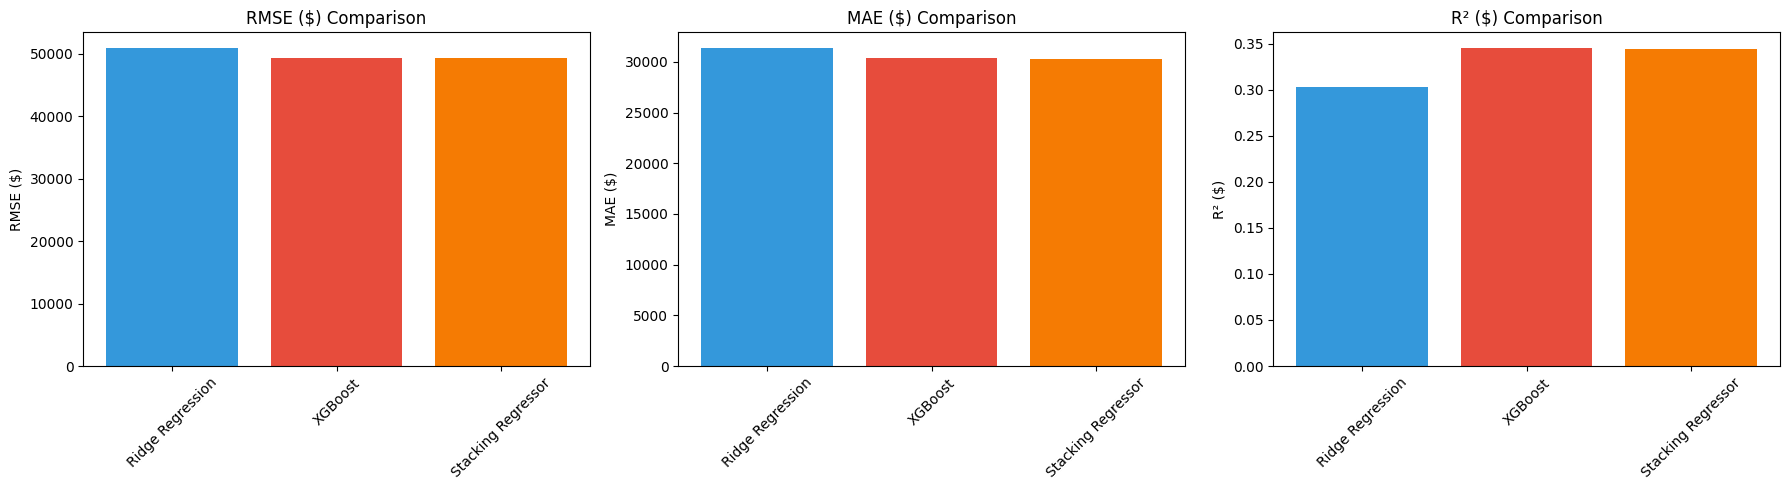

Best Model: XGBoost


In [80]:
comparison_df = pl.DataFrame(
    {
        "Model": ["Ridge Regression", "XGBoost", "Stacking Regressor"],
        "RMSE (log)": [ridge_results["rmse_log"], xgb_val["rmse_log"], stacking_results["rmse_log"]],
        "MAE (log)": [ridge_results["mae_log"], xgb_val["mae_log"], stacking_results["mae_log"]],
        "R² (log)": [ridge_results["r2_log"], xgb_val["r2_log"], stacking_results["r2_log"]],
        "RMSE ($)": [ridge_results["rmse_orig"], xgb_val["rmse_orig"], stacking_results["rmse_orig"]],
        "MAE ($)": [ridge_results["mae_orig"], xgb_val["mae_orig"], stacking_results["mae_orig"]],
        "R² ($)": [ridge_results["r2_orig"], xgb_val["r2_orig"], stacking_results["r2_orig"]],
    }
)

print("\n📊 Model Comparison (Validation Set):")
display(comparison_df)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["RMSE ($)", "MAE ($)", "R² ($)"]
for ax, metric in zip(axes, metrics):
    ax.bar(
        comparison_df["Model"],
        comparison_df[metric],
        color=["#3498db", "#e74c3c", "#F57B03"],
    )
    ax.set_title(f"{metric} Comparison")
    ax.set_ylabel(metric)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "model_comparison.png", dpi=300)
plt.show()

# Winner
best_model = comparison_df.filter(
    pl.col("RMSE ($)") == pl.col("RMSE ($)").min()
)["Model"][0]
print(f"Best Model: {best_model}")

## Residual Analysis

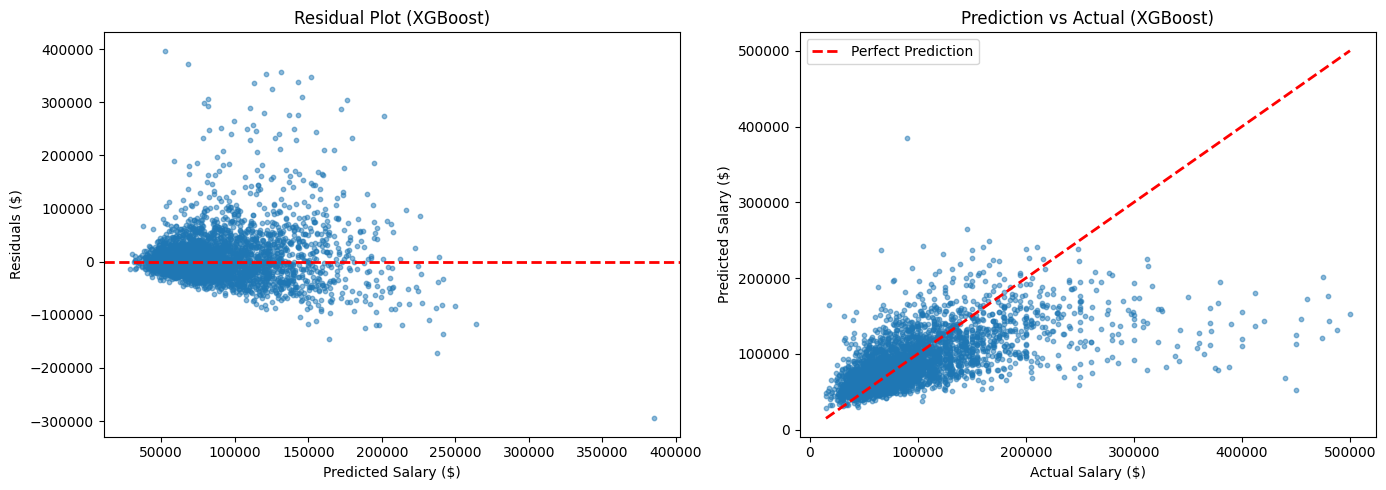

Residual Analysis:
  Mean Residual: $7,632.76
  Std Residual: $48,705.26
  95% of predictions within: $95,462.31 of actual


In [69]:
best_model_obj = xgb_model

y_val_pred_log = best_model_obj.predict(X_val)
y_val_actual = np.expm1(y_val_log.to_numpy())
y_val_pred = np.expm1(y_val_pred_log)

residuals = y_val_actual - y_val_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(y_val_pred, residuals, alpha=0.5, s=10)
axes[0].axhline(0, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("Predicted Salary ($)")
axes[0].set_ylabel("Residuals ($)")
axes[0].set_title("Residual Plot (XGBoost)")

# Prediction vs Actual
axes[1].scatter(y_val_actual, y_val_pred, alpha=0.5, s=10)
axes[1].plot(
    [y_val_actual.min(), y_val_actual.max()],
    [y_val_actual.min(), y_val_actual.max()],
    "r--",
    linewidth=2,
    label="Perfect Prediction",
)
axes[1].set_xlabel("Actual Salary ($)")
axes[1].set_ylabel("Predicted Salary ($)")
axes[1].set_title("Prediction vs Actual (XGBoost)")
axes[1].legend()

plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "residual_analysis.png", dpi=300)
plt.show()

# Analyze residuals
print(f"Residual Analysis:")
print(f"  Mean Residual: ${residuals.mean():,.2f}")
print(f"  Std Residual: ${residuals.std():,.2f}")
print(
    f"  95% of predictions within: ${1.96 * residuals.std():,.2f} of actual"
)